In [5]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns

# Linear algrebra
import numpy as np


# Technical indicators
from scipy.signal import savgol_filter, convolve, lfilter
from ta.trend import ema_indicator, trix, dpo

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope, computeSuperTrend
from modules.Utils.filters import lowpassfilter, fft_denoiser , polynomialRegression, explicit_heat_smooth

from statsmodels.tsa.filters.hp_filter import hpfilter

def filterData(data, method='savgol')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'savgol'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 30, 2, mode='nearest')
    elif method=='hpf':
        cycle, trend = hpfilter(data,120)
        return trend

In [41]:
SYMBOL= 'BTC'
df = loadFromDB(SYMBOL, '15m').iloc[-4000:]
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
print(df.shape)
df.head()

(3981, 7)


,Open,High,Low,Close,Volume,Timestamp,EMA20
Date,,,,,,,
2022-09-05 06:15:00,19762.41,19769.71,19744.00,19760.04,1995.25706,1662358500,19812.597868
2022-09-05 06:30:00,19760.04,19767.03,19725.06,19744.96,1795.41788,1662359400,19806.156166
2022-09-05 06:45:00,19744.96,19802.00,19733.63,19787.20,2327.02811,1662360300,19804.350817
2022-09-05 07:00:00,19786.75,19797.42,19750.77,19753.65,2244.50708,1662361200,19799.522168
2022-09-05 07:15:00,19753.65,19778.72,19706.41,19731.18,2651.58770,1662362100,19793.013390


In [2]:
from tsmoothie.regression_basis import cubic_spline
from tsmoothie.smoother import ConvolutionSmoother, LowessSmoother, KalmanSmoother, PolynomialSmoother, ExponentialSmoother, WindowWrapper

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.01, iterations=2)
smoother.smooth(df["EMA20"].values)

#smoother = ConvolutionSmoother(50,'bartlett')
#smoother = ExponentialSmoother(1, 0.3)
#
#smoother.smooth(df.EMA20.values.reshape(1, -1))
 
df['EMA20_denoised'] =smoother.smooth_data[0]#savgol_filter(df.EMA20.values, 25, 2, mode='nearest')#filterData(df.EMA20.values,'hpf')#
df['EMA20_diff'] = df.EMA20_denoised.diff(1)#.diff(1)

df

NameError: name 'df' is not defined

In [49]:
X = df.EMA20.iloc[:-1].values
y = df.EMA20.iloc[1:].values
X,y

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X.reshape(-1, 1),y)
lr.score(X.reshape(-1, 1),y)

0.9999392936727756

AttributeError: 'DataFrame' object has no attribute 'EMA20'

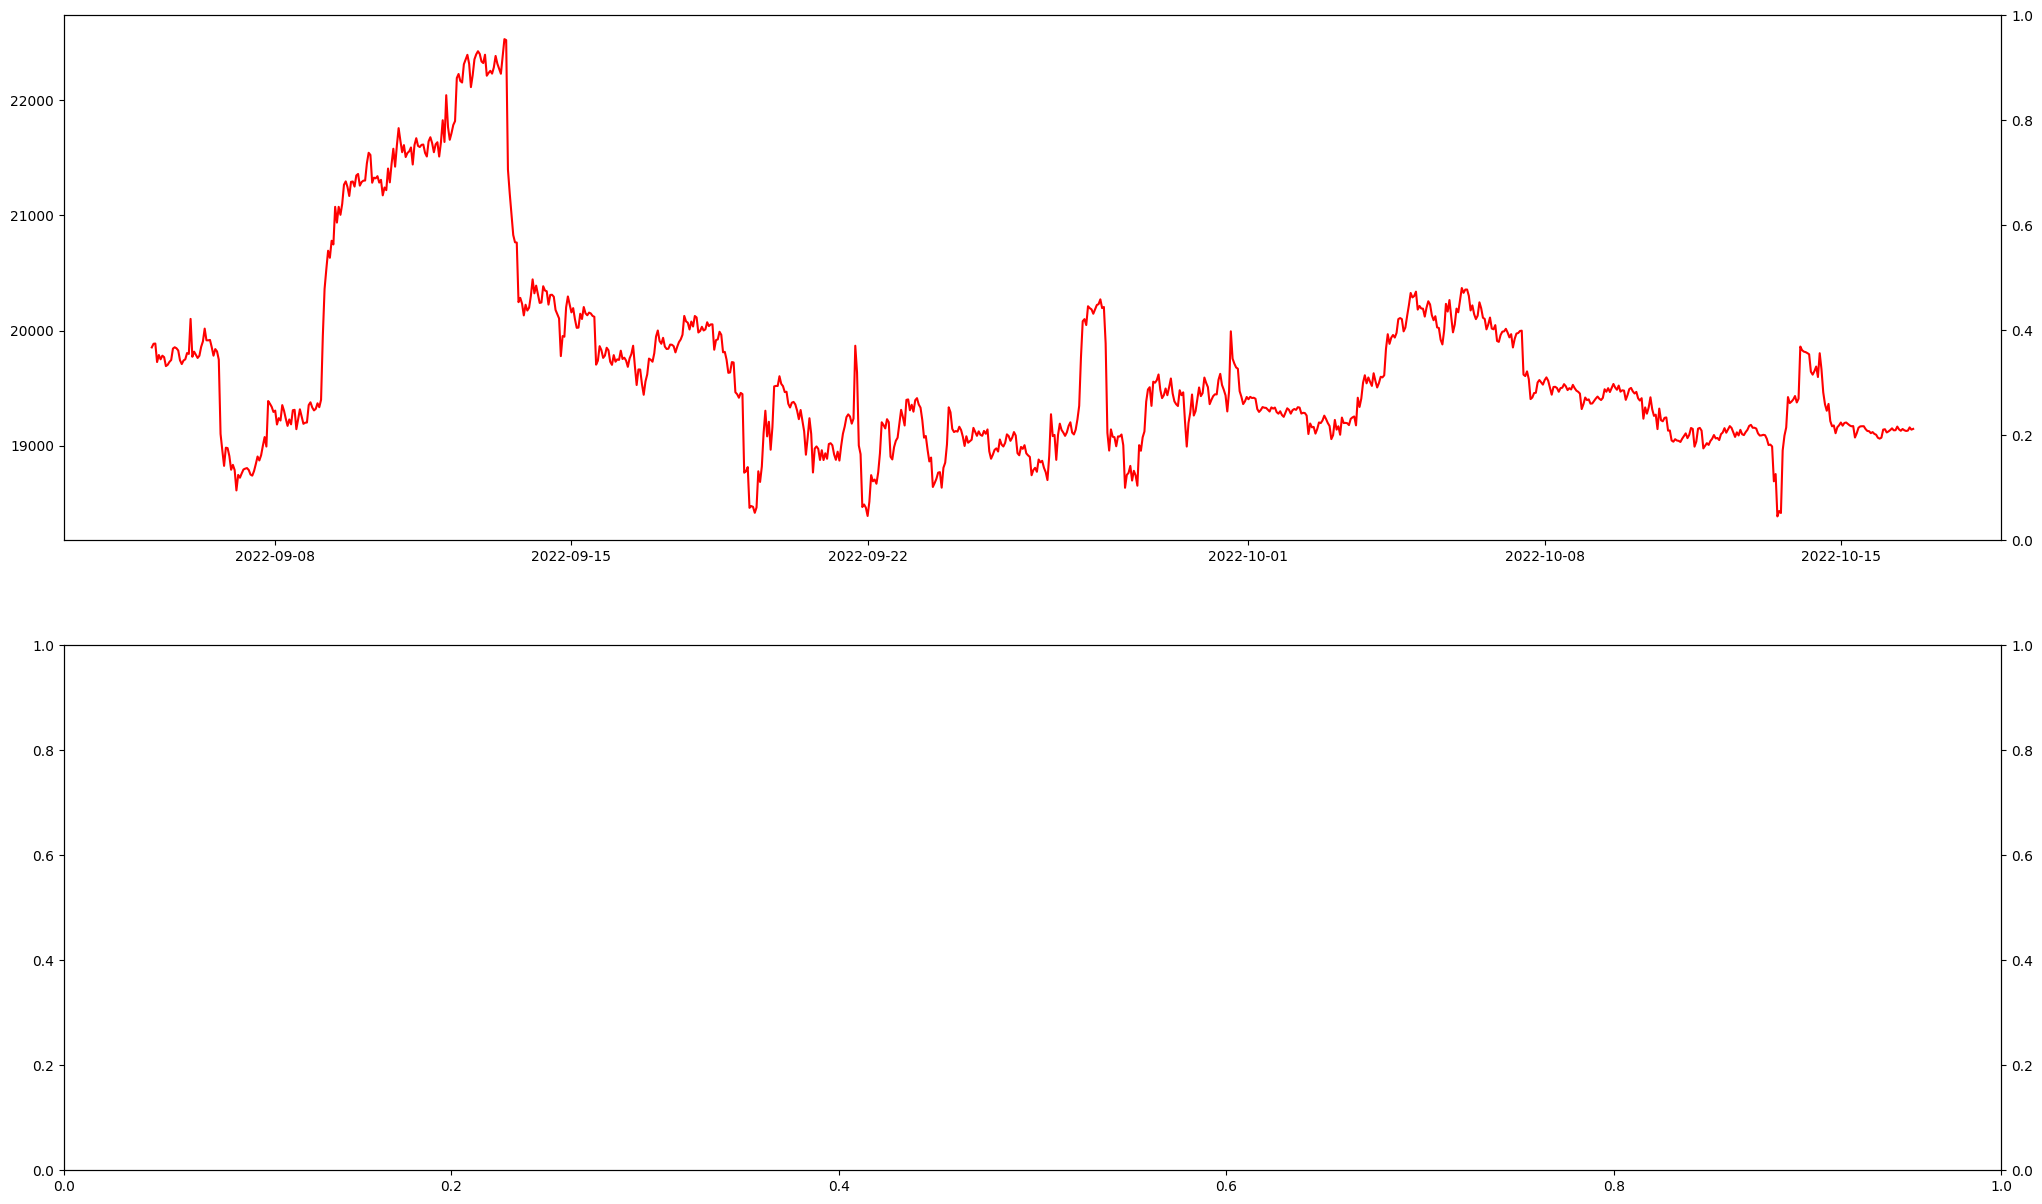

In [24]:
fig, ax_left = plt.subplots(2, figsize=(25,15))
ax_right =[]

ind=1000

ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.Close[-ind:], color='red',label='Close')
ax_left[0].plot(df.EMA20[-ind:], color='blue',label='EMA20')
ax_right[0].plot(df.EMA20_denoised[-ind:], color='orange',label='EMA20_denoised')
ax_left[0].legend(loc="upper left")
#ax_right[0].plot(df.EMA20_diff[-ind:], color='orange',label='EMA20_deoised_diff')
#ax_right[0].axhline(y=0, color='black')
ax_right[0].legend(loc="upper right")

ax_left[1].plot(df.EMA20[-ind:], color='blue',label='EMA20')
ax_left[1].plot(df.EMA20_denoised[-ind:], color='yellow',label='EMA20_denoised')
ax_right[1].plot(df.EMA20_diff[-ind:], color='red',label='EMA20_deoised_diff')
ax_right[1].axhline(y=0, color='black')
ax_left[1].legend(loc="upper left")
ax_right[1].legend(loc="lower right")
#sns.histplot(data=df['B_MLR_coefs'], ax = ax_leRSIft[1])

Period : [2020-01-01 06:00:00] -> [2022-09-05 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 451934482028.1 $
Performance vs US Dollar : 45193448102.81 %
Buy and Hold Performence : 173.52 %
Performance vs Buy and Hold : 26044882623.1 %
Best trade : +19.45 %, the 2020-12-17 19:30:00
Worst trade : -2.98 %, the 2021-01-11 12:00:00
Worst drawBack : -5.0 %
Total fees :  86913693228.74 $

----- Trades Informations -----
Total trades on period : 1951
Number of positive trades : 1494
Number of negative trades :  457
Trades win rate ratio : 76.58 %
Average trades performance : 1.12 %
Average positive trades : 1.55 %
Average negative trades : -0.31 %

----- Plot -----


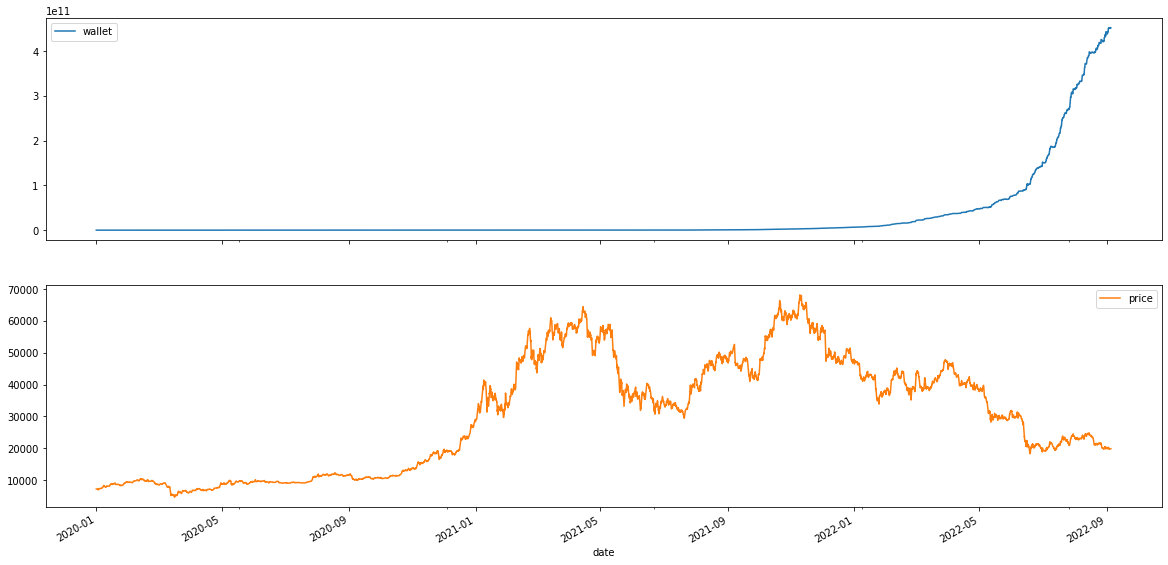

In [4]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# New calculation (inloop filtering)

In [19]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df["EMA20"] = ema_indicator(df["Close"], 20)
df.dropna(inplace=True)
df['EMA20_denoised'] =filterData(df.EMA20.values,'hpf')
#savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)
print(df.shape)
df.head()

(21784, 9)


,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA20_denoised,EMA20_diff
Date,,,,,,,,,
2020-01-01 20:00:00,7240.1,7240.1,7224.9,7229.0,13.119735,1577905200,7217.651537,7224.161809,NaN
2020-01-01 21:00:00,7229.0,7240.0,7227.0,7236.9,15.305158,1577908800,7219.484724,7221.964799,-2.197010
2020-01-01 22:00:00,7236.8,7239.4,7226.6,7234.2,16.852126,1577912400,7220.886179,7219.713536,-2.251262
2020-01-01 23:00:00,7234.1,7234.1,7190.0,7198.0,38.299173,1577916000,7218.706543,7217.333102,-2.380434
2020-01-02 00:00:00,7198.0,7202.3,7180.0,7200.2,18.005546,1577919600,7216.944015,7214.758349,-2.574753


Period : [2020-01-01 20:00:00] -> [2022-08-29 00:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 121629210.99 $
Performance vs US Dollar : 12162821.1 %
Buy and Hold Performence : 175.21 %
Performance vs Buy and Hold : 6941660.58 %
Best trade : +29.49 %, the 2020-04-30 15:00:00
Worst trade : -4.78 %, the 2021-01-12 14:00:00
Worst drawBack : -5.0 %
Total fees :  6133915.67 $

----- Trades Informations -----
Total trades on period : 367
Number of positive trades : 313
Number of negative trades :  54
Trades win rate ratio : 85.29 %
Average trades performance : 3.42 %
Average positive trades : 4.1 %
Average negative trades : -0.55 %

----- Plot -----


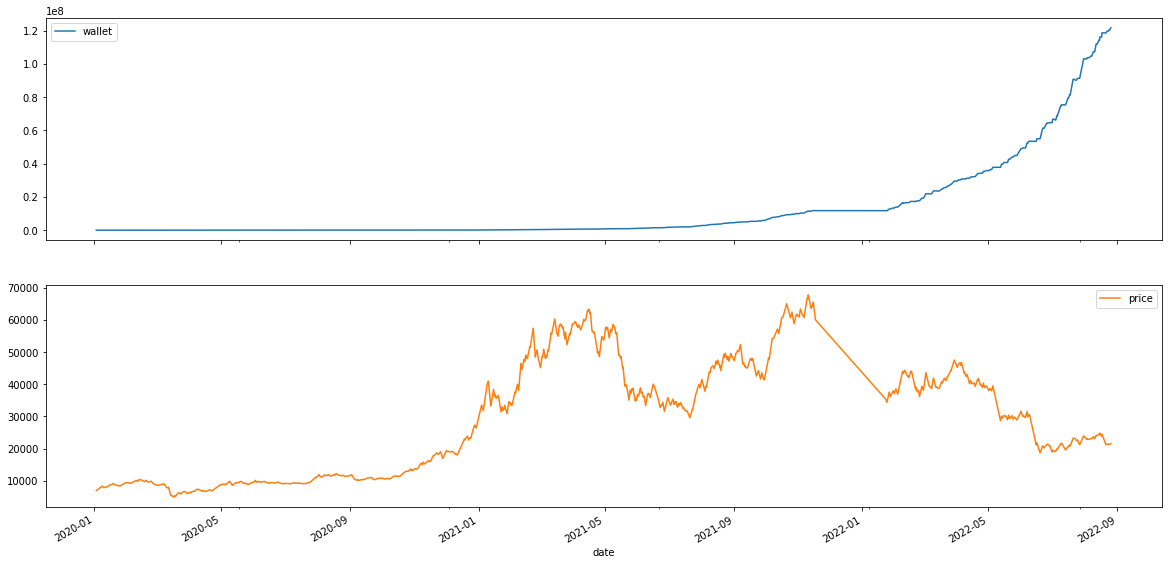

In [12]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.EMA20_diff<0 else False

strategyTester(df.iloc[1000:],buyCondition,sellCondition,equity=1000)

In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocess import cpu_count
results=[]

SYMBOL= 'BTC'
df = loadFromDB(SYMBOL,'1h',False)
df_day = loadFromDB(SYMBOL,'1d')
df_day = computeSuperTrend(df_day)
df_day.dropna(inplace=True)
def addST(x):
    try:
        return df_day.loc[pd.to_datetime(x.name).date().strftime("%Y-%m-%d")].ST_Direction
    except:
        return np.nan
    
df['ST_day'] = df.apply(addST,axis=1)
df.dropna(inplace=True)
df = df.iloc[-4000:]


for window in range(5,50,5):
    for polyorder in range(2,150,15):
        
        df_final = pd.DataFrame()

        def process_one_row(df_i):
            df_i['EMA20'] = ema_indicator(df_i["Close"], window)
            df_i.dropna(inplace=True)
            #fft_denoiser   
            cycle, trend = hpfilter( df_i['EMA20'].values,polyorder) #trend
            df_i['EMA20_denoised'] =trend#explicit_heat_smooth(df_i.EMA20.values, 4)#polynomialRegression(df_i.Close.values,5,False)#savgol_filter(df_i.Close.values, 100, 2, mode='nearest')#filterData(df.EMA20.values,'hpf')#
            df_i['EMA20_diff'] = df_i.EMA20_denoised.diff(1)
            df.dropna(inplace=True)
            return df_i.iloc[-1]
            
        with ThreadPoolExecutor(max_workers=20) as executor:
            processes = [executor.submit(process_one_row, df.iloc[i-1500:i]) for i in range(1500,len(df))]

        for task in as_completed(processes):
            df_final = df_final.append(task.result())
            
        df_final.sort_index(inplace=True)

        #print('Testing strategy : ')
        def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
            return True if row.EMA20_diff>0  and row.ST_day==True else False

        def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
            return True if row.EMA20_diff<0 else False

        coins = strategyTester(df_final,buyCondition,sellCondition,equity=1000, optimization_process=True)
        result = {'window':window,'polyorder':polyorder,'coins':coins}
        print(result)
        results.append(result)

{'window': 5, 'polyorder': 2, 'coins': 807.53}
{'window': 5, 'polyorder': 17, 'coins': 892.64}
{'window': 5, 'polyorder': 32, 'coins': 863.74}
{'window': 5, 'polyorder': 47, 'coins': 907.78}
{'window': 5, 'polyorder': 62, 'coins': 918.86}
{'window': 5, 'polyorder': 77, 'coins': 926.46}
{'window': 5, 'polyorder': 92, 'coins': 927.74}
{'window': 5, 'polyorder': 107, 'coins': 916.59}
{'window': 5, 'polyorder': 122, 'coins': 889.6}
{'window': 5, 'polyorder': 137, 'coins': 892.98}
{'window': 10, 'polyorder': 2, 'coins': 955.85}
{'window': 10, 'polyorder': 17, 'coins': 970.28}
{'window': 10, 'polyorder': 32, 'coins': 986.05}
{'window': 10, 'polyorder': 47, 'coins': 987.13}
{'window': 10, 'polyorder': 62, 'coins': 989.3}
{'window': 10, 'polyorder': 77, 'coins': 988.08}
{'window': 10, 'polyorder': 92, 'coins': 982.81}
{'window': 10, 'polyorder': 107, 'coins': 970.72}
{'window': 10, 'polyorder': 122, 'coins': 960.51}
{'window': 10, 'polyorder': 137, 'coins': 967.75}
{'window': 15, 'polyorder': 